# *Relaxation and Decoherence* 


This notebook gives examples for how to use the ``ignis.characterization.coherence`` module for measuring $T_1$ and $T_2$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import qiskit
from qiskit.providers.aer.noise.errors.standard_errors import thermal_relaxation_error
from qiskit.providers.aer.noise import NoiseModel

from qiskit.ignis.characterization.coherence import T1Fitter, T2StarFitter, T2Fitter
from qiskit.ignis.characterization.coherence import t1_circuits, t2_circuits, t2star_circuits

To estimate $T_{1}$ and $T_{2}$ times, we need to run certain structured circuits (an "experiment design"). Qiskit's `characterization` module provides easy helper functions for generating such circuits.

# Estimating $T_{1}$ time

## Generate the $T_1$ experiment design

In a $T_{1}$ experiment, we start with a qubit in the $|0\rangle$ state, and then excite the qubit to the $|1\rangle$ state using and $X$-gate. We then wait some number of time steps (delays), and measure the probability the qubit is still in the $|1\rangle$ state.

Below, we set the delay to be some number of identity gates (``iden``); the gate time for an identity gate is available from the backend being characterized. Here, we hard-code it as .1 micro-seconds.

Because the $T_1$ time is measured from a fit of the results of circuits with _varying_ delays, we have to specify the minimum and maximum delays.

In [2]:
# Set the number of identity gates to be used in the circuits.
# Here, the minimum number of gates is 10, and the maximum, 300.
# We step in units of 50.
num_of_gates = (np.linspace(10, 300, 50)).astype(int)

# We hard-code the gate time for the identity as .1 micro-seconds.
gate_time = 0.1

# We specify which qubit(s) we want to measure T1 times for.
# Note that it is possible to measure several qubits in parallel
qubits = [0]

The function `t1_circuits` will return both the circuits and delay information. The former we run on the hardware or simulator, and the latter, we use later for fitting purposes.

In [3]:
t1_circs, t1_xdata = t1_circuits(num_of_gates, gate_time, qubits)

Let's take a look at the first and last circuits. Note that _barriers_ are inserted into the circuits to prevent Qiskit's transpiler from collapsing the identity gates.

In [4]:
# As expected, there are 10 identity gates, separated by barriers.
t1_circs[0].draw()

┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
q0_0: ┤ X ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
c0: 1/════════════════════════════════════════════════════════════════════════»
                                                                              »
«      ┌───┐ ░ ┌───┐ ░  ░ ┌─┐
«q0_0: ┤ I ├─░─┤ I ├─░──░─┤M├
«      └───┘ ░ └───┘ ░  ░ └╥┘
«c0: 1/════════════════════╩═
«                          0

In [5]:
t1_circs[-1].draw()

┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
q0_0: ┤ X ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
c0: 1/════════════════════════════════════════════════════════════════════════»
                                                                              »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q0_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c0: 1/════════════════════════════════════════════════════════════════════════»
«                                                                              »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q0_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c0: 1/════════════════════════════════════════════════════════════════════════»
«                                                                              »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q0_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c0: 1/════════════════════════════════════════════════════════════════════════»
«                                                                              »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q0_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c0: 1/════════════════════════════════════════════════════════════════════════»
«                                                                              »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q0_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c0: 1/════════════════════════════════════════════════════════════════════════»
«                                                                              »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q0_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c0: 1/════════════════════════════════════════════════════════════════════════»
«                                                                              »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q0_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c0: 1/════════════════════════════════════════════════════════════════════════»
«                                                                              »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q0_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c0: 1/════════════════════════════════════════════════════════════════════════»
«                                                                              »
«      ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q0_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«      └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«c0: 1/════════════════════════════════════════════════════════════════════════»
«                                         

In addition to the circuits in the experiment design, `t1_circuits` also returns the delay times. These are calculated as (number of identity gates) * (time per identity gate).

In [6]:
# For the first circuit, there are 10 identities, so the delay time is (.1)*10 = 1 micro-second
t1_xdata

array([ 1. ,  1.5,  2.1,  2.7,  3.3,  3.9,  4.5,  5.1,  5.7,  6.3,  6.9,
        7.5,  8.1,  8.6,  9.2,  9.8, 10.4, 11. , 11.6, 12.2, 12.8, 13.4,
       14. , 14.6, 15.2, 15.7, 16.3, 16.9, 17.5, 18.1, 18.7, 19.3, 19.9,
       20.5, 21.1, 21.7, 22.3, 22.8, 23.4, 24. , 24.6, 25.2, 25.8, 26.4,
       27. , 27.6, 28.2, 28.8, 29.4, 30. ])

## Simulate running a T1 experiment

### Building a noise model

To get an intuition for what the $T_{1}$ time is, and how properties of the hardware affect it, we'll use a noisy simulation to mock up running the experiment design on real hardware.

We'll assume the hardware has  a $T_1$ time of 25 micro-seconds.

In [110]:
t1_true = 25.0

# Instantiate the noise model
t1_noise_model = NoiseModel()

# Add an error corresponding to thermal relaxation
# which acts on the identity gate.
# In the noise model, we have to specify which qubit(s) the noise
# acts on.
# We also set the T2 time of the qubits in the model to be the maximum allowed
# by the T1 time; namely, 2*T1
t1_noise_model.add_quantum_error(
    thermal_relaxation_error(t1_true, 2*t1_true, gate_time), 
    'id', [0])

### Run the simulation

In [14]:
# Run the simulator, where we mock up repeating each circuit
# in the experiment design 500 times ("shots").
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 500

t1_backend_result = qiskit.execute(t1_circs, backend, shots=shots,
                                   noise_model=t1_noise_model, optimization_level=0).result()

The `t1_backend_result` contains the results("counts") from running the circuits in the simulator. We can access the results associated with the $j^{th}$ circuit in the experiment design by using `.get_counts(j)`.

In [23]:
# Look at results for the first and last circuits  in the experiment design.
t1_backend_result.get_counts(0), t1_backend_result.get_counts(-1)

({'0': 10, '1': 490}, {'0': 349, '1': 151})

For the first circuit, most of the counts are `1`, meaning the qubit survived. But for the last circuit, most are `0`, meaning it decayed.

We estimate the rate of decay to get an estimate of the $T_{1}$ time.

### Fit the data

We estimate the $T_{1}$ time by fitting the data of delay times and survival probabilities to the following model:
$$ \mathrm{Pr(survival)} = Ae^{-t/T_{1}} + B.$$

The fit to this model is done using the `T1Fitter` function. This function includes keyword arguments which ask us to specify initial guesses and bounds on $(A,T_{1}, B)$.

In [25]:
# The ordering of the guesses and bounds goes (A, T_{1}, B)
t1_fit = T1Fitter(t1_backend_result, t1_xdata, qubits,
                  fit_p0=[1, t1_true, 0],
                  fit_bounds=([0, 0, -1], [2, 40, 1]))

From this fit object, we can extract several quantities of interest, including an estimated $T_{1}$ time.

First though, let's plot the data to see what's going on.

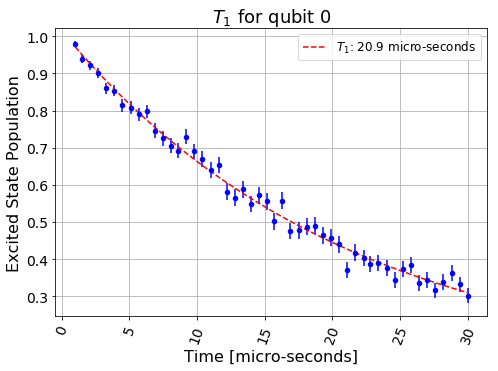

In [139]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

# Specify we want the decay curve for qubit 0.
t1_fit.plot(0, ax=ax)

As the delay time increases, the probability the qubit remains in the $|1\rangle$ state goes down.

The data is fit to an exponential curve, and the coefficient of decay is the estimated $T_{1}$ time.

Let's check what the fit parameters are:

In [35]:
print('Estimated A, T_1, B:', t1_fit.params)
print('Error bars on the estimates:', t1_fit.params_err)

Estimated A, T_1, B: {'0': [array([ 0.92609787, 20.93352597,  0.08906729])]}
Error bars on the estimates: {'0': [array([0.03340909, 1.50231787, 0.03647368])]}


If we wanted just the $T_{1}$ time and error, we can use some convenience functions:

In [36]:
print('Estimated $T_{1}$ time (micro-seconds):', t1_fit.time()[0])
print('Error bars on the estimate (micro-seconds):', t1_fit.time_err()[0])


Estimated $T_{1}$ time (micro-seconds): 20.933525972368177
Error bars on the estimate (micro-seconds): 1.5023178748495103


# Estimate $T_{2}$ time 

## Generate a $T_{2}$ experiment design

TALK ABOUT FACT SEVERAL KINDS OF T2 experiment designs

### Basic $T_2$ experiment design

In a $T_{2}$ experiment, FILL IN!

Below, we set the delay to be some number of identity gates (``iden``); the gate time for an identity gate is available from the backend being characterized. Here, we hard-code it as .1 micro-seconds.

Because the $T_2$ time is measured from a fit of the results of circuits with _varying_ delays, we have to specify the minimum and maximum delays.

In [103]:
# Set the number of identity gates to be used in the circuits.
# Here, the minimum number of gates is 10, and the maximum, 300.
# We step in units of 50.
num_of_gates = (np.linspace(5, 150, 25)).astype(int)

# We hard-code the gate time for the identity as .1 micro-seconds.
gate_time = 0.1

# We specify which qubit(s) we want to measure T2 times for.
# Note that it is possible to measure several qubits in parallel
qubits = [0]

In [104]:
t2echo_circs, t2echo_xdata = t2_circuits(num_of_gates,
                                         gate_time, qubits, n_echos=1, phase_alt_echo=False)

In [105]:
t2echo_circs[0].draw()

┌─────────┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
q27_0: ┤ U2(0,0) ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ Y ├─░─┤ I ├─░─»
       └─────────┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
c27: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
«       ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌─────────┐ ░ ┌─┐
«q27_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ U2(0,0) ├─░─┤M├
«       └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └─────────┘ ░ └╥┘
«c27: 1/═══════════════════════════════════════════════╩═
«                                                      0

### A slightly more sophisticated experiment design using an $RZ$ gate

In [106]:
t2star_circs, t2star_xdata, osc_freq = t2star_circuits(num_of_gates, gate_time, qubits, nosc=5)

In [107]:
t2star_circs[0].draw()

┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌──────────┐┌───┐ ░ ┌─┐
q28_0: ┤ H ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ U1(pi/3) ├┤ H ├─░─┤M├
       └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └──────────┘└───┘ ░ └╥┘
c28: 1/═════════════════════════════════════════════════════════════════════╩═
                                                                            0

### An even more sophisticated experiment design using CPMG-based circuits

In [108]:
t2cpmg_circs, t2cpmg_xdata = t2_circuits(num_of_gates, 
                                         gate_time, qubits, 
                                         n_echos=1, phase_alt_echo=True)

In [109]:
t2cpmg_circs[0].draw()

┌─────────┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
q29_0: ┤ U2(0,0) ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ Y ├─░─┤ I ├─░─»
       └─────────┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
c29: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
«       ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌─────────┐ ░ ┌─┐
«q29_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ U2(0,0) ├─░─┤M├
«       └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └─────────┘ ░ └╥┘
«c29: 1/═══════════════════════════════════════════════╩═
«                                                      0

## Simulate Running a $T_{2}$ experiment

We'll use a simulator, and a noise model, to mock up running these circuits on hardware.

### Building a noise model

In [111]:
# Assume the true T2 time is 25 micro-seconds
t2_true = 25.0


t2_noise_model = NoiseModel()

# Notice that here we assume the T1 time is infinite,
# so that contributions to decays caused by T1 processes
# is zero.
t2_noise_model.add_quantum_error(
    thermal_relaxation_error(np.inf, t2_true, gate_time, 0.5), 
    'id', [0])

## Run the simulation

In [119]:
# Run the simulator, where we mock up repeating each circuit
# in the experiment design 500 times ("shots").
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 500

t2star_backend_result = qiskit.execute(t2star_circs, backend, shots=shots,
                                       noise_model=t2_noise_model, optimization_level=0).result()
t2echo_backend_result = qiskit.execute(t2echo_circs, backend, shots=shots,
                                       noise_model=t2_noise_model, optimization_level=0).result()
t2cpmg_backend_result = qiskit.execute(t2cpmg_circs, backend,
                                        shots=shots, noise_model=t2_noise_model,
                                        optimization_level=0).result()

The `*_backend_result` objects contain the results("counts") from running the circuits in the simulator. We can access the results associated with the $j^{th}$ circuit in the experiment design by using `.get_counts(j)`.

In [121]:
t2star_backend_result.get_counts(0), t2echo_backend_result.get_counts(0), t2cpmg_backend_result.get_counts(0)

({'0': 367, '1': 133}, {'0': 489, '1': 11}, {'0': 490, '1': 10})

Note that each experiment design has a different structure to the circuits, so getting different counts is to be expected.

### Fit the data

#### $T_{2}^{\star}$ time

For estimating the $T_{2}^{\star}$ time, the data is fit to the model

$$ \mathrm{Pr(qubit~is~0)} = 2Ae^{-t/T_{2}^{\star}}\cos(2\pi f t + \phi) + B$$

In [123]:
t2star_fit = T2StarFitter(t2star_backend_result, t2star_xdata, qubits,
                          fit_p0=[0.5, t2_true, osc_freq, 0, 0.5],
                          fit_bounds=([-0.5, 0, 0, -np.pi, -0.5],
                                      [1.5, 40, 2*osc_freq, np.pi, 1.5]))

Let's plot the data and the fit.

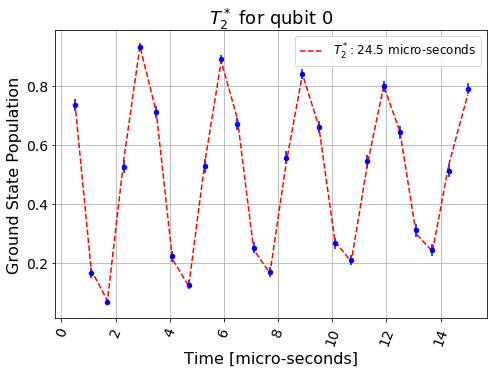

In [140]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

# Specify we want the decay curve for qubit 0.
t2star_fit.plot(0, ax=ax)

Let's check the fit parameters:

In [130]:
print('Estimated (A, T2*, f, phi, B):', t2star_fit.params)
print('Error bars on the estimates:', t2star_fit.params_err)

Estimated (A, T2*, f, phi, B): {'0': [array([5.00627047e-01, 2.44718234e+01, 3.33482350e-01, 3.40039537e-03,
       4.97847854e-01])]}
Error bars on the estimates: {'0': [array([5.88109137e-03, 1.06501984e+00, 3.40446764e-04, 1.46066118e-02,
       2.11045569e-03])]}


And if we're only interested in the estimated $T_{2}^{\star}$ time (and its error), we use the `.time()` and `

In [132]:
print('Estimated T2* time (micro-seconds):', t2star_fit.time())
print('Estimated error bars (micro-seconds):', t2star_fit.time_err())

Estimated T2* time (micro-seconds): [24.471823396730247]
Estimated error bars (micro-seconds): [1.0650198444490124]


#### $T_{2}$ time

For estimating the $T_{2}$ time, the data is fit to the model

$$ \mathrm{Pr(qubit~is~0)} = Ae^{-t/T_{2}} + B$$

Here, we can use both the echoed and CPMG circuits to see how the experiment design impacts the estimate.

In [133]:
t2echo_fit = T2Fitter(t2echo_backend_result, t2echo_xdata, qubits,
                      fit_p0=[0.5, t2_true, 0.5],
                      fit_bounds=([-0.5, 0, -0.5],
                                  [1.5, 40, 1.5]))

t2cpmg_fit = T2Fitter(t2cpmg_backend_result,
                      t2cpmg_xdata, qubits,
                      fit_p0=[0.5, t2_true, 0.5],
                      fit_bounds=([-0.5, 0, -0.5],
                                  [1.5, 40, 1.5]))

Let's plot the data.

Text(0.5, 1.0, 'CPMG circuits')

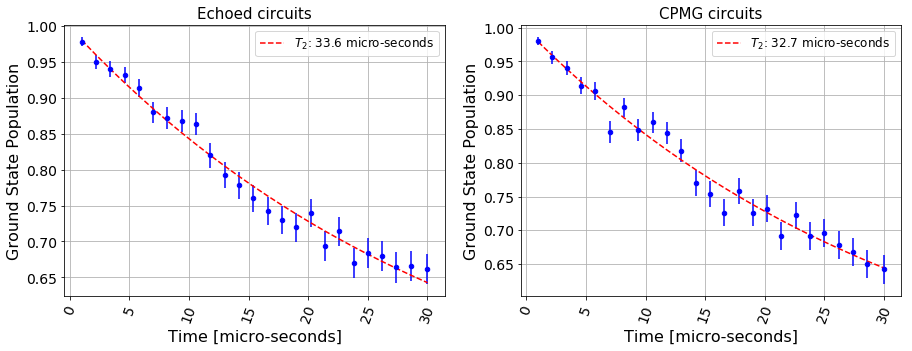

In [150]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(1, 2, 1)
t2echo_fit.plot(0, ax=ax)
ax.set_title('Echoed circuits', fontsize=15)

ax = fig.add_subplot(1, 2, 2)
t2cpmg_fit.plot(0, ax=ax)
ax.set_title('CPMG circuits', fontsize=15)

The data are similar, but there is variation.

In [138]:
print('Using the echoed circuits, the estimated $T_{2}$ time is:', t2echo_fit.time())
print('The error bars are estimated to be ', t2echo_fit.time_err())
print('')

print('Using the echoed circuits, the estimated $T_{2}$ time is:', t2echo_fit.time())
print('The error bars are estimated to be ', t2echo_fit.time_err())

Using the echoed circuits, the estimated $T_{2}$ time is: [33.604745219339236]
The error bars are estimated to be  [7.655364242546427]



In [2]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright